In [1]:
import os
import sys
working_dir = os.path.join(os.getcwd().split("Text2BGAudio")[0],'Text2BGAudio')
sys.path.append(working_dir)
os.chdir(working_dir)
from datasets import load_dataset
from transformers import ClapModel, ClapProcessor
import torch
import matplotlib.pyplot as plt
import torch.nn.functional as F
from collections import Counter,defaultdict


from Dataset_Creation import audio_dataset
from torch.utils.data import DataLoader
if torch.cuda.is_available():
    DEVICE = torch.device("cuda:0")
    print("Device Name:", torch.cuda.get_device_name(DEVICE))
else:
    DEVICE = torch.device("cpu")
    print("Device Name: CPU")


c:\Users\amitmils\Documents\Repo\Text2BGAudio\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Device Name: NVIDIA GeForce RTX 4080 SUPER


In [2]:
model_name = "laion/larger_clap_music"
model = ClapModel.from_pretrained(model_name).to(DEVICE)
processor = ClapProcessor.from_pretrained(model_name)
model.load_state_dict(torch.load(r"C:\Users\amitmils\Documents\Repo\Text2BGAudio\CLAP\models\clap_fine_tunned_BatchSize_32_LR_1e-05_Epochs_50_LOSS_27.06.pt")['model_state_dict'])


C:\Users\amitmils\AppData\Local\Temp\ipykernel_30640\1995541974.py:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(r"C:\Users\amitmils\Docu

<All keys matched successfully>

In [3]:
music_test_dataset = audio_dataset.AudioDataset(r"_Data\Music\music_dataset_test_size128.pt")
data_loader = DataLoader(music_test_dataset, batch_size=len(music_test_dataset), shuffle=True)


In [4]:
for batch in data_loader:
    audio = batch[0]
    labels = list(batch[1])
    unique_labels = list(set(labels))
    inputs = processor(
        text=unique_labels,
        audios=audio.numpy(),
        return_tensors="pt",
        sampling_rate=48000,
        padding=True,
    )
    inputs = {k: v.to(DEVICE) for k, v in inputs.items()}
    outputs = model(**inputs)
    text_embeds = outputs.text_embeds
    audio_embeds = outputs.audio_embeds

In [5]:
label_counts = Counter(labels)

# Print the counts
print(label_counts)

Counter({'Sad': 51, 'Scary': 26, 'Joy': 21, 'Angry': 10, 'Surprise': 10, 'Love': 10})


In [6]:
audio_embeddings = F.normalize(audio_embeds, p=2, dim=1)
text_embeddings = F.normalize(text_embeds, p=2, dim=1)

In [7]:
similarity_matrix = torch.mm( text_embeddings,audio_embeddings.t())


In [8]:
len(unique_labels)


6

In [9]:
similarity_matrix.shape

torch.Size([6, 128])

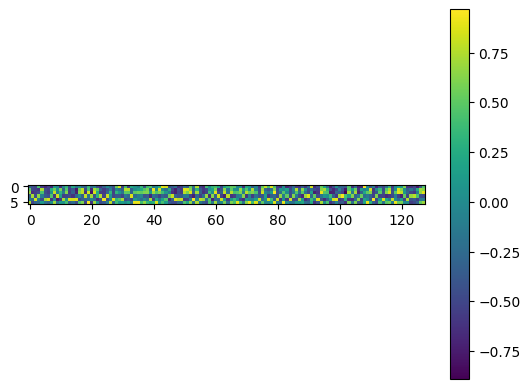

In [10]:
plt.imshow(similarity_matrix.cpu().detach().numpy())
plt.colorbar()

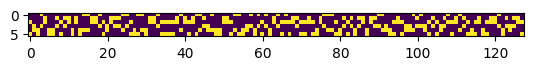

In [11]:
# Assuming similarity_matrix is your input matrix
similarity_matrix = similarity_matrix.cpu().detach()

# Create a new matrix of the same shape filled with zeros
binary_matrix = torch.zeros_like(similarity_matrix)

# Get the indices of the two largest values in each column
topk_indices = torch.topk(similarity_matrix, k=2, dim=0).indices

# Set the two largest values to 1
binary_matrix[topk_indices, torch.arange(similarity_matrix.size(1)).unsqueeze(0).expand(2, -1)] = 1

# Plot the binary matrix
plt.imshow(binary_matrix.cpu().detach().numpy())
plt.show()


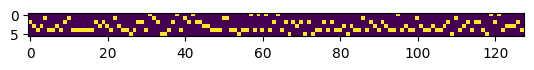

In [12]:
gt_matrix = torch.zeros(similarity_matrix.shape)
for col in range(len(audio_embeddings)):
    gt_matrix[unique_labels.index(labels[col]),col] = 1

plt.imshow(gt_matrix.cpu().detach().numpy())


In [13]:
results = (gt_matrix.cpu() == 1) & (binary_matrix.cpu() == 1)
torch.count_nonzero(results) / gt_matrix.shape[1]

tensor(0.7500)

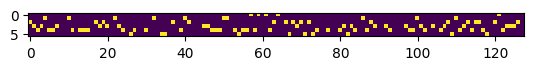

In [14]:
plt.imshow(results)

In [ ]:
from IPython.display import Audio
audio_cpu = audio.cpu().detach()
sample_rate = 16000*3  # Example sample rate, change it to your actual sample rate

id = 0
# Play the audio
Audio(audio_cpu[id], rate=sample_rate)

for i in binary_matrix[:,id].nonzero():
    print(unique_labels[i])

Scary
Surprise
